# Modelo CNN de reconocimiento emocional

Este notebook carga un modelo `.h5` previamente entrenado y realiza inferencia sobre imágenes sueltas para detectar emociones faciales.


In [2]:
!pip install matplotlib

## Librerias


In [3]:

import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt


2025-06-13 03:21:23.418844: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-13 03:21:23.424290: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-13 03:21:23.441809: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749802883.478123   44395 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749802883.489973   44395 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749802883.512530   44395 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Carga del modelo

In [4]:
model_path = '../models/modelo_emocion.h5'
model = tf.keras.models.load_model(model_path, compile=False) #modificar modelo preentrenado por uno mas actual para no usar el compile=False
print("Modelo cargado correctamente")

2025-06-13 03:21:26.901074: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Modelo cargado correctamente


## Carga y preprocesamiento

In [5]:
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64))  # FER2013 size
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)
    return img


## Función para detectar caras


In [8]:
def detectar_caras(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    return img, gray, faces

## Prediccion

In [9]:
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def predict_emotion(img_path):
    img = preprocess_image(img_path)
    preds = model.predict(img)
    class_idx = np.argmax(preds)
    emotion = emotion_labels[class_idx]
    return emotion, preds[0]


## Prueba

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Top 3 emociones:
  Neutral: 32.2%
  Angry: 30.2%
  Fear: 18.6%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Top 3 emociones:
  Happy: 47.3%
  Sad: 35.1%
  Neutral: 12.4%


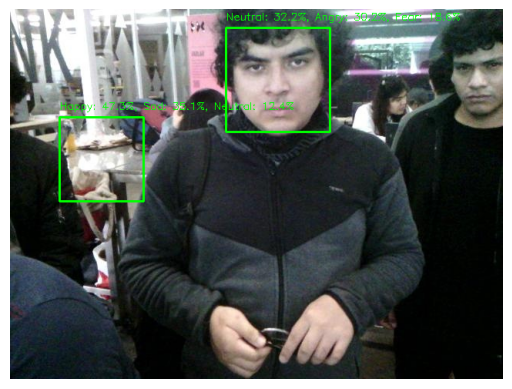

In [11]:
img_path = '../data/test_imgs/enojaos.jpg'  
img, gray, faces = detectar_caras(img_path)

for (x, y, w, h) in faces:
    face_img = gray[y:y+h, x:x+w]
    face_img = cv2.resize(face_img, (64, 64))
    face_img = face_img / 255.0
    face_input = np.expand_dims(face_img, axis=(0, -1))

    preds = model.predict(face_input)[0]
    top3_idx = preds.argsort()[-3:][::-1]
    top3 = [(emotion_labels[i], preds[i]) for i in top3_idx]

    label_text = ', '.join([f"{e}: {s*100:.1f}%" for e, s in top3])
    cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 2)
    cv2.putText(img, label_text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0,255,0), 1)

    print("Top 3 emociones:")
    for e, s in top3:
        print(f"  {e}: {s*100:.1f}%")

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()